# Assignment: Lab 04 - Hedonic Pricing
## Krishu Wadhwa - euj7fh
## October 28, 2024

In [72]:
# imports 

import requests
import urllib.request
import streamlit as st
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

**1. Clean the data and perform some EDA and visualization to get to know the data set.**

In [48]:
url = 'https://raw.githubusercontent.com/DS3001/labs/refs/heads/main/04_hedonic_pricing/cars_hw.csv' # url of data
cars = pd.read_csv(url, low_memory=False) # read csv from url

cars = cars.drop(cars.columns[0], axis=1) # first column was unnamed with indexes so just drop (part of cleaning)

print(cars.isnull().sum()) # find if there are any missing values
cars.head()


Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64


,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [31]:
cars['Make'].value_counts() # find how many of each brand

Make
Hyundai          305
Maruti Suzuki    293
Honda             73
Renault           68
Ford              52
Toyota            50
MG Motors         35
Volkswagen        29
Tata              23
Mahindra          18
Kia                8
Chevrolet          6
Skoda              5
Nissan             4
Jeep               4
Datsun             3
Name: count, dtype: int64

In [32]:
cars['Body_Type'].value_counts() # find how many of each type

Body_Type
hatchback    484
sedan        227
suv          206
muv           38
crossover     21
Name: count, dtype: int64

In [40]:
pd.options.display.float_format = '{:,.0f}'.format # change format to display normal ints instead of scientific notation for price
prices_distribution = cars.groupby('Make')[['Price']].describe() # find stats of make by price
prices_distribution

Price                                                    \
              count      mean       std       min       25%       50%   
Make                                                                    
Chevrolet         6   453,500   246,606   267,000   288,500   345,500   
Datsun            3   289,667    10,504   279,000   284,500   290,000   
Ford             52   721,173   140,928   290,000   635,000   707,500   
Honda            73   798,973   266,509   316,000   581,000   785,000   
Hyundai         305   691,892   279,160   248,000   485,000   638,000   
Jeep              4 1,499,500   152,513 1,290,000 1,447,500 1,529,500   
Kia               8 1,614,750   119,057 1,369,000 1,579,000 1,628,500   
MG Motors        35 1,869,457   121,661 1,589,000 1,786,500 1,848,000   
Mahindra         18 1,100,167   175,549   796,000 1,037,000 1,094,500   
Maruti Suzuki   293   588,785   216,020   237,000   411,000   527,000   
Nissan            4   884,250   289,560   475,000   782,500   978,000   
Renault          68   662,574   214,827   287,000   475,000   644,000   
Skoda             5 1,136,000 1,070,175   436,000   466,000   538,000   
Tata             23 1,055,217   557,831   188,000   779,500   869,000   
Toyota           50   800,340   246,690   368,000   526,250   894,000   
Volkswagen       29   605,828   119,831   402,000   542,000   607,000   

                                   
                    75%       max  
Make                               
Chevrolet       537,500   892,000  
Datsun          295,000   300,000  
Ford            787,000 1,066,000  
Honda           915,000 1,537,000  
Hyundai         837,000 1,742,000  
Jeep          1,581,500 1,649,000  
Kia           1,705,750 1,741,000  
MG Motors     1,978,000 2,019,000  
Mahindra      1,157,000 1,465,000  
Maruti Suzuki   764,000 1,163,000  
Nissan        1,079,750 1,106,000  
Renault         801,000 1,164,000  
Skoda         1,299,000 2,941,000  
Tata          1,552,000 2,100,000  
Toyota        1,023,000 1,092,000  
Volkswagen      699,000   790,000

In [34]:
mileage_distribution = cars.groupby('Make')[['Mileage_Run']].describe() # find stats of make by mileage
mileage_distribution

Mileage_Run                                                 \
                    count          mean           std      min       25%   
Make                                                                       
Chevrolet             6.0  60127.333333  15307.694192  42222.0  46935.25   
Datsun                3.0  57323.000000  15901.002264  42187.0  49038.50   
Ford                 52.0  44727.903846  27741.211135   6886.0  20391.75   
Honda                73.0  41720.493151  22886.391587   7434.0  20604.00   
Hyundai             305.0  46582.878689  24900.471475   1117.0  25517.00   
Jeep                  4.0  49612.750000   7724.133279  43091.0  44150.00   
Kia                   8.0  23599.625000   7241.950979  14077.0  19834.75   
MG Motors            35.0  32332.600000  13168.417963   7339.0  25527.00   
Mahindra             18.0  58353.333333  15765.708678  39894.0  43425.50   
Maruti Suzuki       293.0  38516.334471  23528.253092   2163.0  19958.00   
Nissan                4.0  16453.500000  21546.208955   3832.0   4804.75   
Renault              68.0  34424.044118  23735.020029   4776.0  16313.25   
Skoda                 5.0  60318.200000  37072.808805   9686.0  46103.00   
Tata                 23.0  23416.086957  21997.895941   1540.0   8128.50   
Toyota               50.0  34061.140000  20845.892789   6738.0  14773.75   
Volkswagen           29.0  57142.310345  22537.066188  20427.0  41757.00   

                                           
                   50%       75%      max  
Make                                       
Chevrolet      61975.5  72229.25  77022.0  
Datsun         55890.0  64891.00  73892.0  
Ford           41108.5  68152.50  97902.0  
Honda          43992.0  56221.00  94873.0  
Hyundai        41443.0  64378.00  99001.0  
Jeep           47655.5  53118.25  60049.0  
Kia            22365.5  25978.00  38198.0  
MG Motors      32604.0  40739.00  51686.0  
Mahindra       58701.5  69159.25  94751.0  
Maruti Suzuki  32454.0  54857.00  99495.0  
Nissan          6663.0  18311.75  48656.0  
Renault        26782.5  56666.00  88547.0  
Skoda          52326.0  93981.00  99495.0  
Tata           16123.0  34737.00  92603.0  
Toyota         33394.0  49448.50  73664.0  
Volkswagen     54723.0  81709.00  92227.0

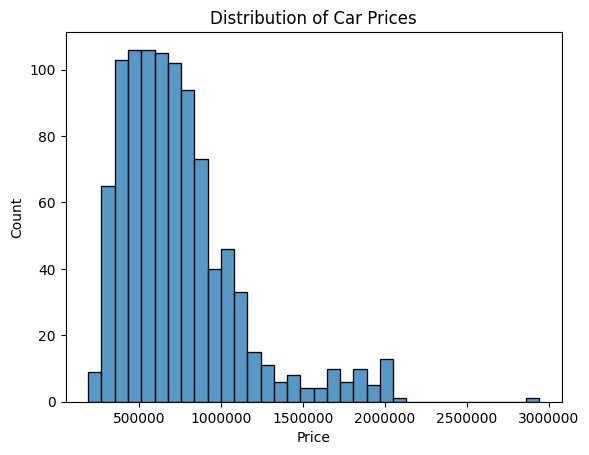

In [49]:
sns.histplot(cars['Price'])
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ticklabel_format(style = 'plain', axis = 'x') 
plt.show()

This is a plot I made to understand the price distribution of cars.

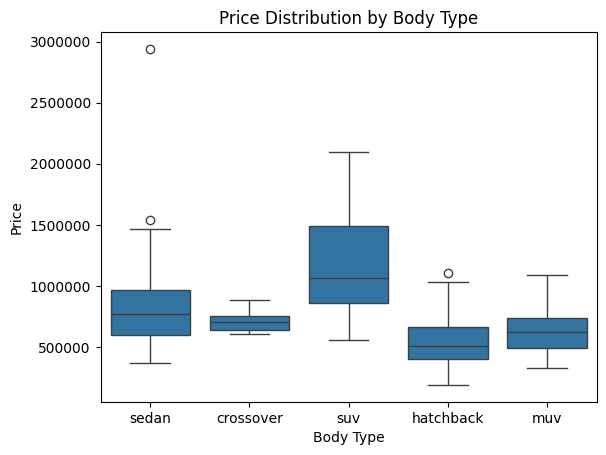

In [47]:
sns.boxplot(data = cars, x = 'Body_Type', y = 'Price')
plt.title('Price Distribution by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Price')
plt.ticklabel_format(style = 'plain', axis = 'y') 
plt.show()

This is a plot I made to understand the price distribution of cars based on their body types.

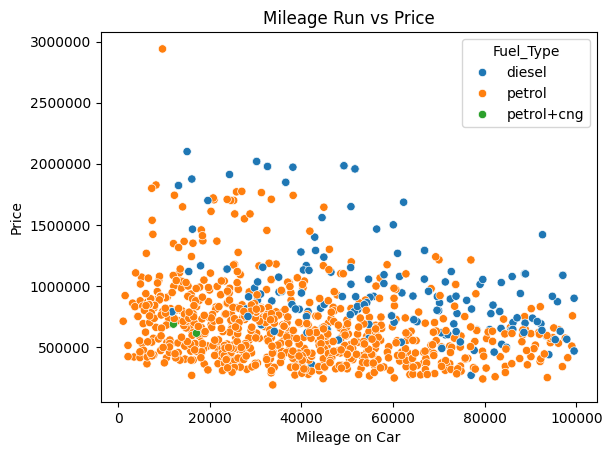

In [52]:
sns.scatterplot(x = 'Mileage_Run', y = 'Price', hue = 'Fuel_Type', data=cars)
plt.title('Mileage Run vs Price')
plt.xlabel('Mileage on Car')
plt.ylabel('Price')
plt.ticklabel_format(style = 'plain', axis = 'y') 
plt.show()

This is a plot I made to understand how cars are priced based on their different fuel types and mileage levels.

**2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.**

In [68]:
categorical = ['Transmission', 'Transmission_Type', 'No_of_Owners', 'Color', 'Make', 'Body_Type', 'Fuel_Type']

y = cars['Price']
X = pd.get_dummies(cars[categorical], dtype = 'int', drop_first = True)

regression = linear_model.LinearRegression(fit_intercept = True).fit(X, y)

intercept = regression.intercept_
print("Intercept: $" + str(intercept))

results = pd.DataFrame({'variable':regression.feature_names_in_, 'coefficient': regression.coef_})
results

Intercept: $260232.71020690282


,variable,coefficient
0,Transmission_5-Speed,"74,619"
1,Transmission_6-Speed,"235,172"
2,Transmission_7-Speed,"538,673"
3,Transmission_CVT,"201,368"
4,Transmission_Type_Manual,"-56,547"
5,No_of_Owners_2nd,"-80,887"
6,No_of_Owners_3rd,"-187,717"
7,Color_black,"193,098"
8,Color_blue,"255,984"
9,Color_bronze,"134,191"


**3. Implement an ~80/~20 train-test split. Put the test data aside.**

In [69]:
y = cars['Price']
X = pd.get_dummies(cars[categorical], dtype = 'int', drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, # 80/20 split
                                                    random_state = 100) 

regression = linear_model.LinearRegression(fit_intercept = True).fit(X_train, y_train)
y_hat = regression.predict(X_test)

print('Rsq: ', regression.score(X_test,y_test))
rmse = np.sqrt(np.mean( (y_test - y_hat) ** 2 ))
print('RMSE: ', rmse) 

intercept = regression.intercept_
print("Intercept: $" + str(intercept))

results = pd.DataFrame({'variable': regression.feature_names_in_, 'coefficient': regression.coef_})
results


Rsq:  0.785511353576235
RMSE:  171613.71299031875
Intercept: $194294.42606771807


,variable,coefficient
0,Transmission_5-Speed,"104,141"
1,Transmission_6-Speed,"267,161"
2,Transmission_7-Speed,"587,336"
3,Transmission_CVT,"223,824"
4,Transmission_Type_Manual,"-63,034"
5,No_of_Owners_2nd,"-78,425"
6,No_of_Owners_3rd,"-237,012"
7,Color_black,"235,464"
8,Color_blue,"250,686"
9,Color_bronze,"155,813"


**4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and R^2 on the both the training and test sets. Which of your models does the best?**

In [70]:
y = cars['Price']
X = pd.get_dummies(cars[categorical], dtype = 'int', drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, # 80/20 split
                                                    random_state = 100) 

regression = linear_model.LinearRegression(fit_intercept = True).fit(X_train, y_train)
y_train_hat = regression.predict(X_train) # training predictor
y_test_hat = regression.predict(X_test) # test predictor

print('Training Rsq: ', regression.score(X_train, y_train))
rmse_train = np.sqrt(np.mean( (y_train - y_train_hat) ** 2 ))
print('Training RMSE: ', rmse_train) 

print('Test Rsq: ', regression.score(X_test, y_test))
rmse_train = np.sqrt(np.mean( (y_test - y_test_hat) ** 2 ))
print('Test RMSE: ', rmse_train) 

intercept = regression.intercept_
print("Intercept: $" + str(intercept))

results = pd.DataFrame({'variable': regression.feature_names_in_, 'coefficient': regression.coef_})
results

Training Rsq:  0.7569962259114917
Training RMSE:  180541.10586995922
Test Rsq:  0.785511353576235
Test RMSE:  171613.71299031875
Intercept: $194294.42606771807


,variable,coefficient
0,Transmission_5-Speed,"104,141"
1,Transmission_6-Speed,"267,161"
2,Transmission_7-Speed,"587,336"
3,Transmission_CVT,"223,824"
4,Transmission_Type_Manual,"-63,034"
5,No_of_Owners_2nd,"-78,425"
6,No_of_Owners_3rd,"-237,012"
7,Color_black,"235,464"
8,Color_blue,"250,686"
9,Color_bronze,"155,813"


The R^2 values for both the training and the test sets are high at 0.757 and 0.786 respectively, indicating a good fit. This shows that 75.6% and 78.6% of the variance in `Price` is explained by the model. Moreover, this similarity (and slight increase) in R^2 for the training and tests suggests a well-generalized model. The RMSE values for the training and test sets are also relatively similar at 180541.106 for the training and 171613.713 for the test. While the test RMSE is slightly lower, suggesting that the model could perform as well on unseen data, the variability in predicted versus actual prices is still quite high. Taking all of this into account, I would say that the test model is better.

**5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and R^2 on the training and test sets. How does the more complex model your build compare to the simpler ones?**

In [71]:
# transform with logs

y = np.log(cars['Price']) # add the transformation (log on price)
X = pd.get_dummies(cars[categorical], dtype = 'int', drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, # 80/20 split
                                                    random_state = 100) 

regression_log = linear_model.LinearRegression(fit_intercept = True).fit(X_train, y_train)
y_train_hat_log = regression.predict(X_train) # training predictor
y_test_hat_log = regression.predict(X_test) # test predictor

print('Training Rsq: ', regression_log.score(X_train, y_train))
rmse_train_log = np.sqrt(np.mean( (y_train - y_train_hat_log) ** 2 ))
print('Training RMSE: ', rmse_train_log) 

print('Test Rsq: ', regression_log.score(X_test, y_test))
rmse_train_log = np.sqrt(np.mean( (y_test - y_test_hat_log) ** 2 ))
print('Test RMSE: ', rmse_train_log) 

intercept_log = regression_log.intercept_
print("Intercept: $" + str(intercept))

results = pd.DataFrame({'variable': regression_log.feature_names_in_, 'coefficient': regression_log.coef_})
results

Training Rsq:  0.6831417533557413
Training RMSE:  804745.5018151824
Test Rsq:  0.6840180343035456
Test RMSE:  809146.3504782548
Intercept: $194294.42606771807


,variable,coefficient
0,Transmission_5-Speed,0
1,Transmission_6-Speed,0
2,Transmission_7-Speed,1
3,Transmission_CVT,0
4,Transmission_Type_Manual,-0
5,No_of_Owners_2nd,-0
6,No_of_Owners_3rd,-0
7,Color_black,0
8,Color_blue,0
9,Color_bronze,0


In [81]:
y = cars['Price'] 
X = pd.get_dummies(cars[categorical], dtype = 'int', drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, # 80/20 split
                                                    random_state = 100) 

poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = False) # include transformations and interactions
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

names = poly.get_feature_names_out(input_features = X.columns)
X_train_poly = pd.DataFrame(X_train_poly, columns = names)
X_test_poly = pd.DataFrame(X_test_poly, columns = names)

regression_poly = linear_model.LinearRegression(fit_intercept = True).fit(X_train_poly, y_train)
y_train_hat_poly = regression_poly.predict(X_train_poly) # training predictor
y_test_hat_poly = regression_poly.predict(X_test_poly) # test predictor

print('Training Rsq: ', regression_poly.score(X_train_poly, y_train))
rmse_train_poly = np.sqrt(np.mean( (y_train - y_train_hat_poly) ** 2 ))
print('Training RMSE: ', rmse_train_poly) 

print('Test Rsq: ', regression_poly.score(X_test_poly, y_test))
rmse_train_poly = np.sqrt(np.mean( (y_test - y_test_hat_poly) ** 2 ))
print('Test RMSE: ', rmse_train_poly) 

intercept_poly = regression_poly.intercept_
print("Intercept: $" + str(intercept_poly))

results = pd.DataFrame({'variable': regression_poly.feature_names_in_, 'coefficient': regression_poly.coef_})
results

Training Rsq:  0.8984720204174774
Training RMSE:  116697.744138854
Test Rsq:  -1.4667995318370334e+24
Test RMSE:  4.487817779341197e+17
Intercept: $6.45158328639873e+17


,variable,coefficient
0,Transmission_5-Speed,"-681,599,799,195,121,792"
1,Transmission_6-Speed,"2,319,237,111,050,627,072"
2,Transmission_7-Speed,"1,847,250,957,451,294,464"
3,Transmission_CVT,"3,821,570,460,097,480,704"
4,Transmission_Type_Manual,"44,885,648,375,608,200"
...,...,...
940,Body_Type_suv Fuel_Type_petrol,"201,332,706,934,721,024"
941,Body_Type_suv Fuel_Type_petrol+cng,0
942,Fuel_Type_petrol^2,"417,249,932,319,573,120"
943,Fuel_Type_petrol Fuel_Type_petrol+cng,0


The simple log-transformed model provided reasonable performance, with training and test R^2 values of 0.683 and 0.684, showing that approximately 68.3% and 68.4% of the variance in `Price` is explained by the model. The RMSE values were around 804745.502 for the training set and 809146.35 for the test set, showing that the model's predictive power was similar across both sets and did not suffer from significant overfitting. However, when looking at the polynomial-transformed model, we saw an extremely high R^2 of about 0.8985 for the training set, showing that approximately 89.85% of the variance in `Price` is explained by the training model. Furthermore, the RMSE was similar as before at around 116697.744. However, the test set had an R^2 in the negatives at -1.467e+24, and an extremely high RMSE of 4.488e+17. This would suggest significant overfitting and shows that the test model cannot work with unseen data. The comparison between the three models shows that while the polynomial model seemed more effective on the training data, it turned out to be unreliable for unseen new and unseen data. The log-transformed model, even though it’s less complex, performed better with unseen data. Still, of the three, I would choose the standard simple model from part 4, as it had the best overall results.

**6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?**

Throughout the analysis, I observed that the simpler models often provided a better and more balanced fit, with consistent R^2 and RMSE values for both the training and the test sets. This shows that there was minimal overfitting/underfitting. The log-transformed model also maintained stable performance, proving to be a reliable choice for generalization. In contrast, the polynomial model showed severe overfitting, performing exceptionally on training data but failing drastically on the test set with a negative R^2 value and a huge RMSE value. This shows that, while complex models might seem to be very powerful, simpler models can often be more reliable and effective. However, it is important to note that more complex model could suit other data sets better, it just so happens to be that this dataset worked better with less drastic transformations.